In [15]:
!pip install keras-tuner

In [34]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.preprocessing import image
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import ConfusionMatrixDisplay, classification_report

import warnings
warnings.filterwarnings('ignore')

In [17]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/Projects/DeepLearning/datasets/covid_xray_dataset/train'
test_dir = '/content/drive/MyDrive/Colab Notebooks/Projects/DeepLearning/datasets/covid_xray_dataset/test'

In [18]:
# getting the training data
def create_df(data_path):
  file_path = []
  file_label = []
  for inst in os.listdir(data_path):
    f_path = os.path.join(data_path, inst)
    if os.path.isdir(f_path):
      images = os.listdir(f_path)
      for img in images:
        img_path = os.path.join(f_path,img)
        file_path.append(img_path)
        file_label.append(inst)

  file_series = pd.Series(file_path, name = 'FilePath')
  label_series = pd.Series(file_label, name = 'Labels')

  return pd.concat([file_series,label_series],axis = 1)

In [19]:
# creating the pandas series for train and test
train_df = create_df(train_dir)
test_df = create_df(test_dir)

In [20]:
train_df.head()

,FilePath,Labels
0,/content/drive/MyDrive/Colab Notebooks/Project...,NORMAL
1,/content/drive/MyDrive/Colab Notebooks/Project...,NORMAL
2,/content/drive/MyDrive/Colab Notebooks/Project...,NORMAL
3,/content/drive/MyDrive/Colab Notebooks/Project...,NORMAL
4,/content/drive/MyDrive/Colab Notebooks/Project...,NORMAL


In [21]:
test_df.head()

,FilePath,Labels
0,/content/drive/MyDrive/Colab Notebooks/Project...,PNEUMONIA
1,/content/drive/MyDrive/Colab Notebooks/Project...,PNEUMONIA
2,/content/drive/MyDrive/Colab Notebooks/Project...,PNEUMONIA
3,/content/drive/MyDrive/Colab Notebooks/Project...,PNEUMONIA
4,/content/drive/MyDrive/Colab Notebooks/Project...,PNEUMONIA


In [22]:
train_df['FilePath'][0]

'/content/drive/MyDrive/Colab Notebooks/Projects/DeepLearning/datasets/covid_xray_dataset/train/NORMAL/IM-0006-0001.jpeg'

In [23]:
# creating synthetic data by data augmentation
train_datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    rescale = 1./255,
    shear_range =0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [24]:
# data generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'FilePath',
    y_col = 'Labels',
    target_size = (244,244),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = True,
    seed = 42
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'FilePath',
    y_col = 'Labels',
    target_size = (244,244),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)

Found 148 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.


In [25]:
# CNN architecture
def build_model(hp):
  model = Sequential([
      Conv2D(filters = hp.Int('conv1_filter',min_value = 32, max_value = 128, step = 8),
             kernel_size = hp.Choice('conv1_kernel',values = [3,4,5,6,7]),
             activation = hp.Choice('conv1_activation',['relu','tanh']),
             input_shape = (244,244,3)),
      MaxPooling2D((2,2)),

      Conv2D(filters = hp.Int('conv2_filter',min_value = 32, max_value = 68, step = 8),
             kernel_size = hp.Choice('conv2_kernel',values = [2,3,4]),
             activation = hp.Choice('conv2_activation',['relu','tanh']),
             padding = 'same'),
      MaxPooling2D((2,2)),

      Conv2D(filters = hp.Int('conv3_filter',min_value = 32, max_value = 68, step = 8),
             kernel_size = hp.Choice('conv3_kernel',values = [2,3,4]),
             activation = hp.Choice('conv3_activation',['relu', 'tanh']),
             padding = 'same'),
      MaxPooling2D((2,2)),

      Flatten(),
      Dense(units = hp.Int('dense1_units',min_value = 120, max_value = 256, step = 8),
            activation = 'relu'),
      Dense(units = hp.Int('dense2_units',min_value = 60, max_value = 120, step = 8),
            activation = 'relu'),
      Dense(2, activation='sigmoid')
  ])

  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

  return model

In [26]:
# tuner for function
tuner = RandomSearch(hypermodel = build_model,
                     objective = 'accuracy',
                     max_trials = 5,
                     project_name = 'Pneumonia_prediction')

Reloading Tuner from ./Pneumonia_prediction/tuner0.json


In [27]:
# using the tuner to serach hyper parameter with image datagenerator
tuner.search(train_generator, epochs = 5,batch_size = 32, validation_data = test_generator)

Trial 5 Complete [00h 00m 54s]
accuracy: 0.7770270109176636

Best accuracy So Far: 0.8243243098258972
Total elapsed time: 00h 33m 00s


In [29]:

best_model = tuner.get_best_models(num_models = 1)[0]

best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 240, 240, 40)   │         3,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 120, 120, 40)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 120, 120, 40)   │         6,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 60, 60, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 32)     │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │     3,456,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 108)            │        13,068 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           218 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,484,038 (13.29 MB)

 Trainable params: 3,484,038 (13.29 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
tuner.results_summary()

Results summary
Results in ./Pneumonia_prediction
Showing 10 best trials
Objective(name="accuracy", direction="max")

Trial 3 summary
Hyperparameters:
conv1_filter: 40
conv1_kernel: 5
conv1_activation: relu
conv2_filter: 40
conv2_kernel: 2
conv2_activation: tanh
conv3_filter: 32
conv3_kernel: 2
conv3_activation: tanh
dense1_units: 120
dense2_units: 108
Score: 0.8243243098258972

Trial 4 summary
Hyperparameters:
conv1_filter: 104
conv1_kernel: 3
conv1_activation: relu
conv2_filter: 40
conv2_kernel: 2
conv2_activation: tanh
conv3_filter: 48
conv3_kernel: 3
conv3_activation: relu
dense1_units: 128
dense2_units: 100
Score: 0.7770270109176636

Trial 2 summary
Hyperparameters:
conv1_filter: 120
conv1_kernel: 7
conv1_activation: relu
conv2_filter: 48
conv2_kernel: 4
conv2_activation: relu
conv3_filter: 32
conv3_kernel: 3
conv3_activation: relu
dense1_units: 224
dense2_units: 76
Score: 0.6554054021835327

Trial 0 summary
Hyperparameters:
conv1_filter: 40
conv1_kernel: 4
conv1_activation: relu


In [31]:
best_model.fit(train_generator, epochs = 10)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6157 - loss: 1.5112
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 996ms/step - accuracy: 0.5647 - loss: 1.1360
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 907ms/step - accuracy: 0.7534 - loss: 0.5629
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7946 - loss: 0.4633
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 957ms/step - accuracy: 0.8154 - loss: 0.4354
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8371 - loss: 0.4700
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 946ms/step - accuracy: 0.8273 - loss: 0.4619
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 979ms/step - accuracy: 0.8142 - loss: 0.3993
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8308 - loss: 0.3719
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8814 - loss: 0.3308


In [32]:
scores = best_model.evaluate(test_generator)
print(scores)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - accuracy: 1.0000 - loss: 0.0709
[0.0764232724905014, 1.0]


In [37]:
y_pred = best_model.predict(test_generator)
y_pred_class = np.argmax(y_pred, axis = 1)
true_class = test_generator.classes

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step


Classification Report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



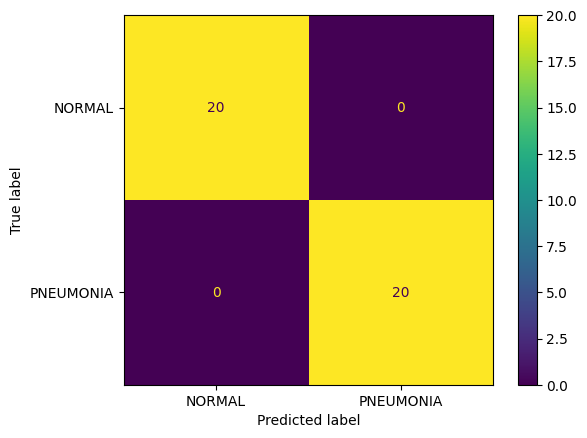

In [38]:
cm = ConfusionMatrixDisplay.from_predictions(true_class, y_pred_class,display_labels = test_generator.class_indices)
print('Classification Report:\n\n',classification_report(ture_class, y_pred_class))

In [39]:
def load_and_preprocess_image(img_path, target_size = (244,244)):
  img = image.load_img(img_path, target_size = target_size)
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis = 0)
  img_array /= 255.0
  return img_array

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


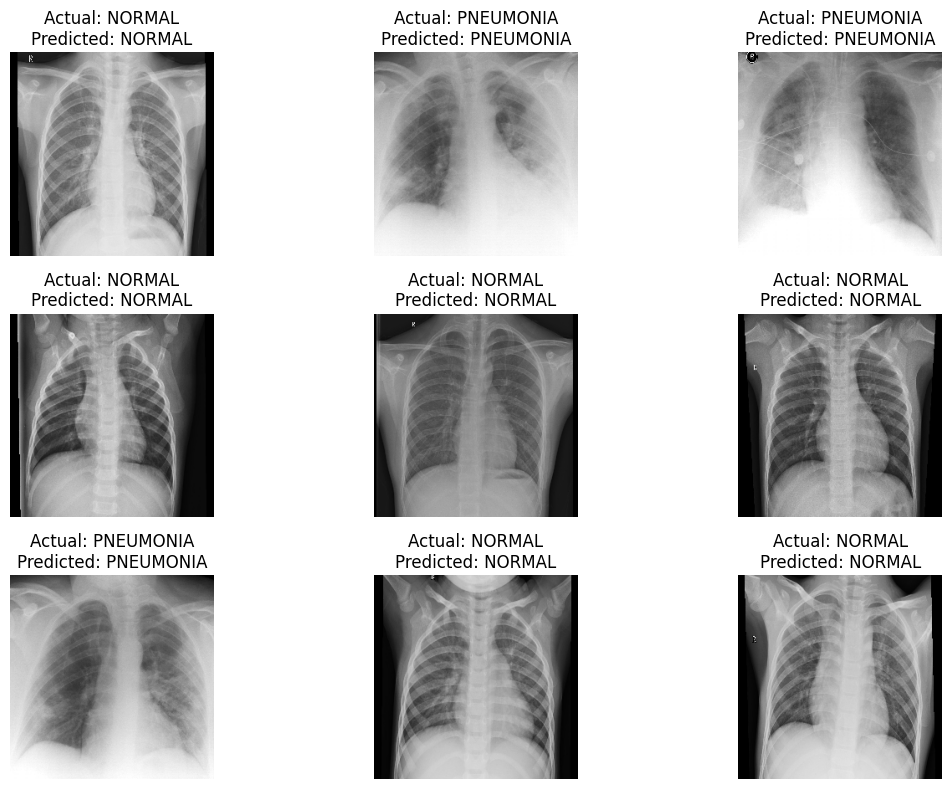

In [43]:
random_indices = random.sample(range(len(test_df)),9)
random_images_path = test_df.iloc[random_indices]['FilePath'].tolist()
random_images_labels = test_df.iloc[random_indices]['Labels'].to_list()

images = [load_and_preprocess_image(img_path) for img_path in random_images_path]
images = np.vstack(images)

predictions = best_model.predict(images)
predicted_classes = predictions.argmax(axis = 1)

class_labels = {v:k for  k, v in train_generator.class_indices.items()}
predicted_labels = [class_labels[idx] for idx in predicted_classes]

plt.figure(figsize = (12,8))
for i, (img_path, actual_label) in enumerate(zip(random_images_path, random_images_labels)):
  img = image.load_img(img_path, target_size = (244, 244))
  plt.subplot(3,3,i+1)
  plt.title(f'Actual: {actual_label}\nPredicted: {predicted_labels[i]}')
  plt.axis('off')
  plt.imshow(img)
plt.tight_layout()
plt.show()